<a href="https://colab.research.google.com/github/Amanislh22/JobClusters/blob/main/FinalSemesterProjectOct_Nov2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

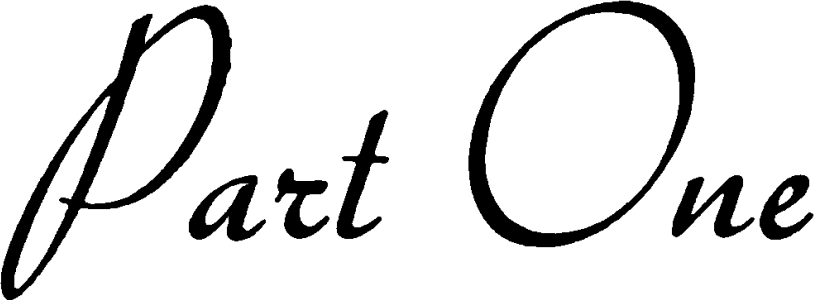

# Prepare our Json files

**Installing scrapy library**

In [ ]:
 pip install scrapy

In [ ]:
%%writefile jobs_1.py
import scrapy

class jobsSpider(scrapy.Spider):
    name = "jobs"
    start_urls = [
        'https://tunisia.tanqeeb.com/s/jobs/jobs-in-tunisia'
    ]

    def parse(self, response):
        for job in response.css('div.card-body'):
            yield {
              'location': job.css('p.h10 > span:nth-child(1)::text').get(),
              'jobTitle': job.css('h5::text').get(),
              'company':job.css(' p.h10 > span:nth-child(2)::text').get(),
              'Add Date':job.css(' p.h10 > span:nth-child(3)::text').get(),
            }
        yield from response.follow_all(css='li.page-item.active > a', callback=self.parse)


Overwriting jobs_1.py


In [ ]:
!scrapy runspider /content/jobs_1.py  -o jobs_1.json

In [ ]:
%%writefile job_2.py
import scrapy

class jobsSpider(scrapy.Spider):
    name = "jobs"
    start_urls = [
      "https://www.farojob.net/jobs"
    ]

    def parse(self, response):
        for job in response.css('article.loadmore-item'):
            yield {
              'location': job.css('div.loop-item-content > p > span.job-location > a > em::text').get(),
              'jobTitle': job.css(' div.loop-item-content > h2 > a::text').get(),
              'company':job.css('div.loop-item-content > p > span.job-company > a::text').get(),
              'Add Date':job.css('div.loop-item-content > p > span.job-date > time > span::text').get(),
            }
        yield from response.follow_all(css='div.pagination.list-center > a.next.page-numbers', callback=self.parse)

Overwriting job_2.py


In [ ]:
!scrapy runspider /content/job_2.py  -o jobs_2.json

# Preparing our DataFrame

In [ ]:
import pandas as pd
df1=pd.read_json("/content/jobs_1.json")
df2=pd.read_json("/content/jobs_2.json")
MyDataFrame =pd.concat([df1, df2],ignore_index=True, sort=False, axis=0)
display(MyDataFrame)
print(" ****** information about our DataFrame ******* ")
print(df1.info())
print(type(MyDataFrame))

,location,jobTitle,company,Add Date
0,Tunisia - Manouba,Acheteur principal,BABA ALI,4 December 2022
1,Tunisia - Tunis,Référent Technique Java / JEE / Kotlin (F/H),Sofrecom Group,4 December 2022
2,Tunisia - Tunis,Business Development Representative - German s...,Expensya,4 December 2022
3,Tunisia - Tunis,Développeur Full Stack PHP / Laravel,Atsu,4 December 2022
4,None,None,None,None
...,...,...,...,...
14415,Tunis,FinLogik recrute un Développeur Web / UI,None,\n18 décembre 2016\n
14416,Tunis,FinLogik recrute un Développeur C# / Azure / F...,None,\n18 décembre 2016\n
14417,Kasserine,Pronto Café recrute des Revendeurs,None,\n14 décembre 2016\n
14418,Tunis,AMSTUNIS recrute un Agent Comptable,None,\n14 décembre 2016\n


 ****** information about our DataFrame ******* 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2725 entries, 0 to 2724
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  2316 non-null   object
 1   jobTitle  2316 non-null   object
 2   company   2316 non-null   object
 3   Add Date  2295 non-null   object
dtypes: object(4)
memory usage: 85.3+ KB
None
<class 'pandas.core.frame.DataFrame'>


# Creating a corpus

In [ ]:
corpus=[]
for i in MyDataFrame['jobTitle']:
  if i !=None :
    corpus.append(i)
print(corpus)

['Acheteur principal', 'Référent Technique Java / JEE / Kotlin (F/H)', 'Business Development Representative - German speaker', 'Développeur Full Stack PHP / Laravel', 'Customer Service Specialist', 'Technical Support Sr. Advisor II Zscaler 1 FTE', 'Sales Executive - Tunisia (They/She/He)', 'Technical Consultant (Bahrain / Sudan / Tunisia / Morocco / Kuwait / Lebanon)', 'AI & Frontend developer (PFE)', 'Senior DEVOPS/SRE engineer', 'Technicien supérieur SIG', 'Assistant Restaurant Manager', 'Web Designer', 'Medical Representative', '(Tunisia) Customer Support Consultant (fluent German)', 'Senior Data Integration Developer', 'Integration Consultant', 'Project Controlling ES Tunisia', 'Consultant systèmes d’information', 'Développeur Fullstack Django React REMOTE', 'Data Analyst (M/F)', 'Hotel Manager', 'ML/NLP Specialist: Smart metadata extractor [Paid end of study internship]', 'Chef Atelier Maintenance des Bouteilles', 'Junior M&A Analyst Intern (H/F)', 'Hotel Manager', 'Quality Assura

# Remove Noise Function For our DataFrame

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punk')
nltk.download('stopwords')
import re
final_stopwords_list = stopwords.words('english') + stopwords.words('french')
def remove_noise(text, stop_words = final_stopwords_list):
    tokens = word_tokenize(text)
    cleaned_tokens = []
    for token in tokens:
        token = re.sub('[^A-Za-z0-9]+', '', token)
        if len(token) > 1 and token.lower() not in stop_words:
            # Get lowercase
            cleaned_tokens.append(token.lower())
    cleaned_tokens = ' '.join(cleaned_tokens)
    return cleaned_tokens

[nltk_data] Error loading punk: Package 'punk' not found in index
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Creating tfidf_matrix

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=remove_noise)

# Use the .fit_transform() method
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

print(tfidf_matrix)


  (0, 22)	0.20333997074265622
  (0, 24)	0.17372065700859063
  (0, 19)	0.3370838034603119
  (0, 26)	0.4780344423895126
  (0, 0)	0.1573443933635638
  (0, 28)	0.31642306779686014
  (0, 31)	0.16792756756211188
  (0, 30)	0.16056696501266524
  (0, 15)	0.3139484768905921
  (0, 18)	0.28633596423790175
  (0, 13)	0.33177058687306926
  (0, 11)	0.3418269795251015
  (1, 25)	0.08436467789467023
  (1, 21)	0.2142320734218817
  (1, 32)	0.15325616958864072
  (1, 20)	0.486544082127033
  (1, 27)	0.22054415078584602
  (1, 16)	0.287904005856671
  (1, 22)	0.09593980473942472
  (1, 24)	0.24589448673180786
  (1, 19)	0.15904278025953694
  (1, 0)	0.3711909252521797
  (1, 28)	0.14929463808126814
  (1, 31)	0.0792315351646495
  (1, 30)	0.22727597355288048
  :	:
  (14009, 25)	0.11546975119103557
  (14009, 22)	0.13131260213437945
  (14009, 24)	0.22437016620959574
  (14009, 19)	0.10884075375850791
  (14009, 26)	0.15435220707164152
  (14009, 0)	0.3048289273628384
  (14009, 28)	0.20433924651407717
  (14009, 31)	0.216888

# Clustering with Kmean

In [ ]:
from sklearn.cluster import KMeans
# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=3, random_state=47)
# fit the model
kmeans.fit(tfidf_matrix)
# store cluster labels in a variable
clusters = kmeans.labels_
print(clusters)
MyDataFrame = pd.DataFrame(data=corpus, columns=['Job Title'])
MyDataFrame["Labels"] = clusters
print(MyDataFrame.info())
MyDataFrame = MyDataFrame.sort_values('Labels')
print(MyDataFrame)

print(type(MyDataFrame))

[1 2 2 ... 2 1 0]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14011 entries, 0 to 14010
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Job Title  14011 non-null  object
 1   Labels     14011 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 164.3+ KB
None
                                               Job Title  Labels
7005               Soprotic recrute un Ingénieur Textile       0
7120   Telec Engineering recrute Assistante de direction       0
7119         Lik consulting recrute en Marketing digital       0
7118                Sotuvit recrute un Agent Billetterie       0
7116   Hotel Continental Kairouan recrute Sous- Chef ...       0
...                                                  ...     ...
943                                Embedded SW developer       2
11277   Wild Wonder Production recrute un(e) Monteur(se)       2
1700                             Journaliste francophone       2
5750       

# Trying to visiualise Data

********************************
 [[ 0.04802904 -0.05292906]
 [ 0.04287986  0.03813908]
 [ 0.17678462  0.14669672]
 ...
 [ 0.27049203 -0.09515906]
 [-0.10847167 -0.04039654]
 [-0.29142637  0.17677148]]
                                               Job Title  Labels  cluster  \
7005               Soprotic recrute un Ingénieur Textile       0        1   
7120   Telec Engineering recrute Assistante de direction       0        2   
7119         Lik consulting recrute en Marketing digital       0        2   
7118                Sotuvit recrute un Agent Billetterie       0        2   
7116   Hotel Continental Kairouan recrute Sous- Chef ...       0        0   
...                                                  ...     ...      ...   
943                                Embedded SW developer       2        2   
11277   Wild Wonder Production recrute un(e) Monteur(se)       2        2   
1700                             Journaliste francophone       2        2   
5750             Alpha servi

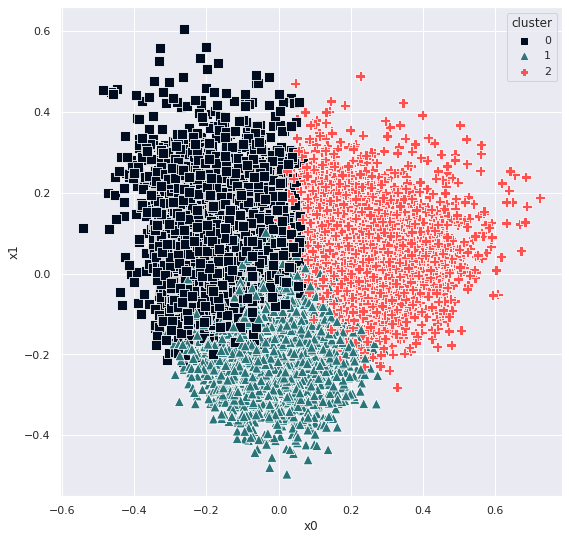

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our matrix to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(tfidf_matrix.toarray())
print("********************************\n",pca_vecs)
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]
# assign clusters and pca vectors to our dataframe
MyDataFrame['cluster'] = clusters
MyDataFrame['x0'] = x0
MyDataFrame['x1'] = x1
print(MyDataFrame)

# palette
knn_palette = sns.color_palette(['#000C1F', '#29757A', '#FF5050'])
# sns.palplot(knn_palette)
# plt.show()
# *****
plt.figure(figsize=(9, 9))
sns.set()
sns.scatterplot(x='x0', y='x1',
                data=MyDataFrame,
                hue='cluster',
                palette=knn_palette,
                # which corresponds to a square , a triangle and a plus
                markers=[',', '^', 'P'],
                # for the markers to show up we need to have labels as the style
                #parameter
                style='cluster',
                # increasing the size of the points
                s=100,
                # ?
                legend=True
                )
plt.show()


# 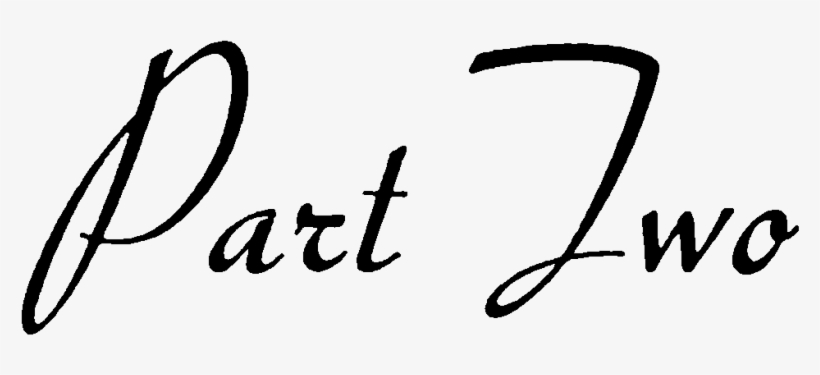

# Creating a spark context and reading the data


In [ ]:
!pip install pyspark
import pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyspark
import pandas as pd
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

df1=pd.read_json("/content/jobs_1.json")
df2=pd.read_json("/content/jobs_2.json")
DataFrame =pd.concat([df1, df2],ignore_index=True, sort=True, axis=0)

jobs_dataFrame=spark.createDataFrame(DataFrame['jobTitle'].to_frame())
print(type(jobs_dataFrame))
jobs_dataFrame.show(n=15 ,  truncate=False)

<class 'pyspark.sql.dataframe.DataFrame'>
+-----------------------------------------------------------------------------+
|jobTitle                                                                     |
+-----------------------------------------------------------------------------+
|Acheteur principal                                                           |
|Référent Technique Java / JEE / Kotlin (F/H)                                 |
|Business Development Representative - German speaker                         |
|Développeur Full Stack PHP / Laravel                                         |
|null                                                                         |
|Customer Service Specialist                                                  |
|Technical Support Sr. Advisor II Zscaler 1 FTE                               |
|Sales Executive - Tunisia (They/She/He)                                      |
|Technical Consultant (Bahrain / Sudan / Tunisia / Morocco / Kuwait / Lebanon)

# Creating a pipeline nd Clustering Using Kmean Algo

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF,IDF, Tokenizer ,VectorAssembler ,StopWordsRemover
from pyspark.ml.clustering import KMeans
from pyspark.mllib.linalg import Vectors
nltk.download('stopwords')

In [ ]:
#A tokenizer that converts the input string to lowercase and then splits it by white spaces.
tokenizer = Tokenizer(inputCol="jobTitle", outputCol="tokens")

 #removing the null results
df = jobs_dataFrame.dropna()

final_stopwords_list = stopwords.words('english') + stopwords.words('french')
remover = StopWordsRemover(inputCol="tokens", outputCol="stopWordsRemovedTokens",stopWords=final_stopwords_list)

#calculate the term frequency tf
hashingTF = HashingTF(inputCol="tokens", outputCol="rawFeatures",numFeatures=200)

#calculate the inverse document frequency
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5)

#Appling the k means algorithm with k = 3 (3 clusters)
kmeans= KMeans(k=3)

#creating the pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, idf, kmeans])

model = pipeline.fit(df)
results = model.transform(df)

display(results)

#print the first 25 rows
results.show(25)



DataFrame[jobTitle: string, tokens: array<string>, stopWordsRemovedTokens: array<string>, rawFeatures: vector, features: vector, prediction: int]

+--------------------+--------------------+----------------------+--------------------+--------------------+----------+
|            jobTitle|              tokens|stopWordsRemovedTokens|         rawFeatures|            features|prediction|
+--------------------+--------------------+----------------------+--------------------+--------------------+----------+
|  Acheteur principal|[acheteur, princi...|  [acheteur, princi...|(200,[55,69],[1.0...|(200,[55,69],[3.8...|         0|
|Référent Techniqu...|[référent, techni...|  [référent, techni...|(200,[51,77,122,1...|(200,[51,77,122,1...|         0|
|Business Developm...|[business, develo...|  [business, develo...|(200,[71,94,152,1...|(200,[71,94,152,1...|         0|
|Développeur Full ...|[développeur, ful...|  [développeur, ful...|(200,[1,52,97,148...|(200,[1,52,97,148...|         0|
|Customer Service ...|[customer, servic...|  [customer, servic...|(200,[13,17,52],[...|(200,[13,17,52],[...|         0|
|Technical Support...|[technical, suppo.

# New Section